## Merlin6 adaptations

On PSI's Merlin6 cluster, this notebook should be run from the GPU queue (launch jupyter with `-p gpu --gres=gpu:1 --account=merlin-gpu`). Then, go to Kernel » Change Kernel » Python \[conda env:cryocare\].

The following changes have been made to this notebook for Merlin6 compatibility:

- Data is stored in ./data rather than /data
- Dose weighting is disabled for reconstruction. This makes it compatible with IMOD 4.9.

# Reconstruct even/odd Tomograms

__Note__: If you want to apply this notebook to your own data, you have to reconstruct the raw tomogram once manually with IMOD. 

The tomogram reconstruction is performed with [IMOD](https://bio3d.colorado.edu/imod/), which is already installed in the singularity image. A pre-requisit for Noise2Noise training is voxel-perfect tomogram registration. We can achieve that by reconstructing the two halves (even/odd) with the exact same parameters. By taking the imod-reconstruction files from a previous reconstruction run on this data, we can enusre that the two reconstructions use identical parameters.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from shutil import copy as cp

from os.path import join, exists

from utils import modify_com_scripts, reconstruct_tomo

import mrcfile
from matplotlib import pyplot as plt

In [3]:
# Path to the parent directory of the even/odd splits
data_path = 'data/Tomo110/frames/'

## Copy Reconstruction Files

In [4]:
# Path to the imod reconstruction files
path_recon_files = 'data/Tomo110/imod/'

In [5]:
def copy_etomo_files(src, name, target):
    if exists(join(src, name + 'local.xf')):
        cp(join(src, name + 'local.xf'), target)
    cp(join(src, name + '.xf'), target)
    cp(join(src, 'eraser.com'), target)
    cp(join(src, 'ctfcorrection.com'), target)
    cp(join(src, 'tilt.com'), target)
    cp(join(src, 'newst.com'), target)
    cp(join(src, name + '.xtilt'), target)
    cp(join(src, name + '.tlt'), target)
    cp(join(src, name + '.defocus'), target)
    cp(join(src, 'rotation.xf'), target)

In [6]:
# We copy the reconstruction files into the two sub-directories containing
# the even/odd data.
copy_etomo_files(path_recon_files, 'Tomo110', data_path + 'even')
copy_etomo_files(path_recon_files, 'Tomo110', data_path + 'odd')

## Modify Reconstruction Files

Now we will modify the binning used during reconstruction. To do so, we have to edit the following files:
* newst.com
* ctfcorrection.com
* tilt.com

We also have to know the pixel-size of our acquisitions.

In [7]:
# We look at the header of the first tilt-angle
!header data/Tomo110/frames/01_Tomo110_64.0_Apr04_15.51.42.mrc


 RO image file on unit   1 : data/Tomo110/frames/01_Tomo110_64.0_Apr04_15.51.42.mrc     Size=     556211 K

 Number of columns, rows, sections .....    7420    7676      10
 Map mode ..............................    0   (byte)                     
 Start cols, rows, sects, grid x,y,z ...    0     0     0    7420   7676     10
 Pixel spacing (Angstroms)..............   2.355      2.355      2.355    
 Cell angles ...........................   90.000   90.000   90.000
 Fast, medium, slow axes ...............    X    Y    Z
 Origin on x,y,z .......................    0.000       0.000       0.000    
 Minimum density .......................   0.0000    
 Maximum density .......................   158.00    
 Mean density ..........................   4.1210    
 tilt angles (original,current) ........   0.0   0.0   0.0   0.0   0.0   0.0
 Space group,# extra bytes,idtype,lens .        0        0        0        0

     1 Titles :
SerialEMCCD: Dose frac. image, scaled by 16.00  r/f 1   04-A

In [8]:
# We extract the pixel spacing in angstroms from the header
p = !header -p data/Tomo110/frames/01_Tomo110_64.0_Apr04_15.51.42.mrc

# We convert from angstroms to nanometers, since the
# imod-files expect pixel-spacing in nanometers.
pixel_spacing = float(p.fields(0)[0])*0.1
print('Pixel Spacing in nanometers:', pixel_spacing)

Pixel Spacing in nanometers: 0.23555000000000004


In [9]:
# Now we modify the imod-files to generate a 6-times binned
# tomogram. The results in the paper were produced on 6 times
# binned data. 
# You can change the binning, but then you might have to change
# the network settings too in the following notebooks. 
modify_com_scripts(join(data_path, 'even'), 6, pixel_spacing)
modify_com_scripts(join(data_path, 'odd'), 6, pixel_spacing)

Modified 'newst.com' file:
# THIS IS A COMMAND FILE TO MAKE AN ALIGNED STACK FROM THE ORIGINAL STACK
#
####CreatedVersion####4.9.2
#
# It assumes that the views are in order in the image stack
#
# The size argument should be ,, for the full area or specify the desired
# size (e.g.: ,10)
#
# The offset argument should be 0,0 for no offset, 0,300 to take an area
# 300 pixels above the center, etc.
#
$newstack -StandardInput
InputFile	Tomo110.st
OutputFile	Tomo110.ali
TransformFile	Tomo110.xf
TaperAtFill	1,0
AdjustOrigin
OffsetsInXandY	0.0,0.0
#DistortionField	.idf
ImagesAreBinned	1.0
BinByFactor     6
#GradientFile	Tomo110.maggrad
$if (-e ./savework) ./savework

------------------------------------------------------------------------

Modified 'ctfcorrection.com' file:
# Command file to run ctfphaseflip
#
####CreatedVersion####4.9.2
#
$ctfphaseflip -StandardInput
InputStack  Tomo110.ali
AngleFile   Tomo110.tlt
OutputFileName	Tomo110_ctfcorr.ali
#
# Defocus file from ctfplotter (see man p

## Reconstruct Tomograms 

In [10]:
# This will write a reconstruction log into 'data/Tomo110/frames/even/Tomo110_reconstruction.log'
# The three 'None' parameters are for backwards compatibility with IMOD/4.9 (which lack dose filtering)
reconstruct_tomo(join(data_path, 'even'), 'Tomo110', None, None, None)  # dfix=1.61, init=3)

newstack 01_Tomo110_64.0_Apr04_15.51.42.mrc 02_Tomo110_62.0_Apr04_15.50.51.mrc 03_Tomo110_60.0_Apr04_15.49.50.mrc 04_Tomo110_58.0_Apr04_15.48.58.mrc 05_Tomo110_56.0_Apr04_15.48.06.mrc 06_Tomo110_54.0_Apr04_15.47.19.mrc 07_Tomo110_52.0_Apr04_15.46.37.mrc 08_Tomo110_50.0_Apr04_15.45.54.mrc 09_Tomo110_48.0_Apr04_15.45.13.mrc 10_Tomo110_46.0_Apr04_15.44.24.mrc 11_Tomo110_44.0_Apr04_15.43.41.mrc 12_Tomo110_42.0_Apr04_15.42.59.mrc 13_Tomo110_40.0_Apr04_15.42.16.mrc 14_Tomo110_38.0_Apr04_15.41.28.mrc 15_Tomo110_36.0_Apr04_15.40.46.mrc 16_Tomo110_34.0_Apr04_15.40.02.mrc 17_Tomo110_32.0_Apr04_15.39.20.mrc 18_Tomo110_30.0_Apr04_15.38.37.mrc 19_Tomo110_28.0_Apr04_15.37.49.mrc 20_Tomo110_26.0_Apr04_15.37.06.mrc 21_Tomo110_24.0_Apr04_15.36.23.mrc 22_Tomo110_22.0_Apr04_15.35.40.mrc 23_Tomo110_20.0_Apr04_15.34.56.mrc 24_Tomo110_18.0_Apr04_15.34.08.mrc 25_Tomo110_16.0_Apr04_15.33.26.mrc 26_Tomo110_14.0_Apr04_15.32.44.mrc 27_Tomo110_12.0_Apr04_15.32.00.mrc 28_Tomo110_10.0_Apr04_15.31.18.mrc 29_Tomo110_

In [11]:
# This will write a reconstruction log into 'data/Tomo110/frames/odd/Tomo110_reconstruction.log'
reconstruct_tomo(join(data_path, 'odd'), 'Tomo110', None, None, None)  # dfix=1.61, init=3)

newstack 01_Tomo110_64.0_Apr04_15.51.42.mrc 02_Tomo110_62.0_Apr04_15.50.51.mrc 03_Tomo110_60.0_Apr04_15.49.50.mrc 04_Tomo110_58.0_Apr04_15.48.58.mrc 05_Tomo110_56.0_Apr04_15.48.06.mrc 06_Tomo110_54.0_Apr04_15.47.19.mrc 07_Tomo110_52.0_Apr04_15.46.37.mrc 08_Tomo110_50.0_Apr04_15.45.54.mrc 09_Tomo110_48.0_Apr04_15.45.13.mrc 10_Tomo110_46.0_Apr04_15.44.24.mrc 11_Tomo110_44.0_Apr04_15.43.41.mrc 12_Tomo110_42.0_Apr04_15.42.59.mrc 13_Tomo110_40.0_Apr04_15.42.16.mrc 14_Tomo110_38.0_Apr04_15.41.28.mrc 15_Tomo110_36.0_Apr04_15.40.46.mrc 16_Tomo110_34.0_Apr04_15.40.02.mrc 17_Tomo110_32.0_Apr04_15.39.20.mrc 18_Tomo110_30.0_Apr04_15.38.37.mrc 19_Tomo110_28.0_Apr04_15.37.49.mrc 20_Tomo110_26.0_Apr04_15.37.06.mrc 21_Tomo110_24.0_Apr04_15.36.23.mrc 22_Tomo110_22.0_Apr04_15.35.40.mrc 23_Tomo110_20.0_Apr04_15.34.56.mrc 24_Tomo110_18.0_Apr04_15.34.08.mrc 25_Tomo110_16.0_Apr04_15.33.26.mrc 26_Tomo110_14.0_Apr04_15.32.44.mrc 27_Tomo110_12.0_Apr04_15.32.00.mrc 28_Tomo110_10.0_Apr04_15.31.18.mrc 29_Tomo110_

## Tomogram Inspection

In [12]:
with mrcfile.open(join(data_path, 'even', 'Tomo110_even.rec')) as mrc:
    even = mrc.data[108]
    
with mrcfile.open(join(data_path, 'odd', 'Tomo110_odd.rec')) as mrc:
    odd = mrc.data[108]

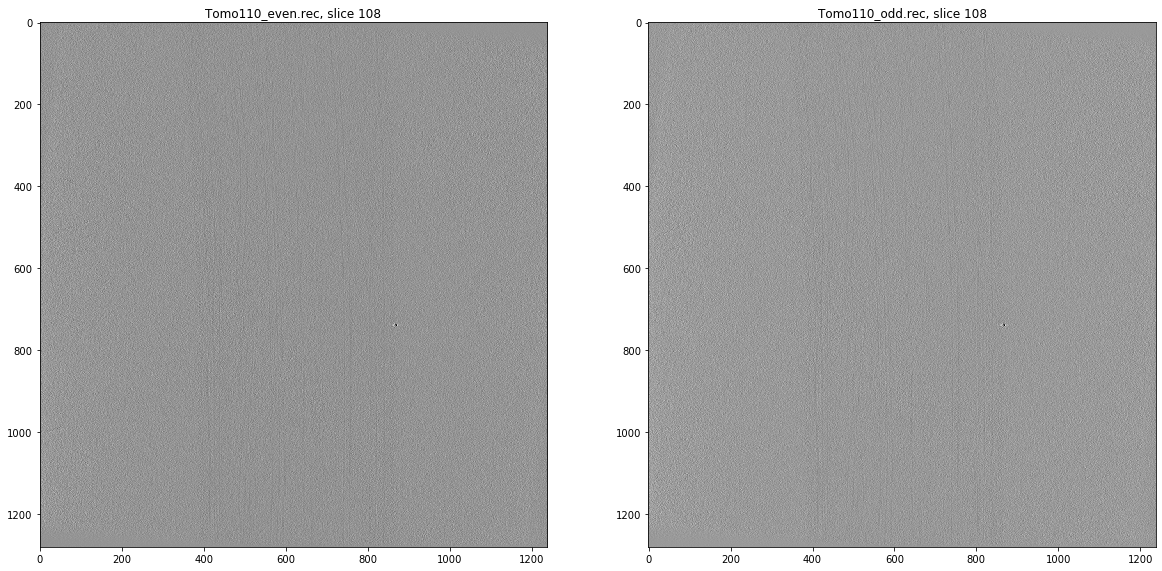

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(even, cmap='gray')
plt.title('Tomo110_even.rec, slice 108');
plt.subplot(1,2,2)
plt.imshow(odd, cmap='gray')
plt.title('Tomo110_odd.rec, slice 108');